<a href="https://colab.research.google.com/github/WilfriKusnadi/superduperimageanalysis/blob/main/analyze_drops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python numpy matplotlib scipy


Saving 7565CC3A-F557-4FA9-A631-3D745373E816.jpeg to 7565CC3A-F557-4FA9-A631-3D745373E816 (6).jpeg
Image dimensions: 3024 x 1973
Total contours detected: 385
Scored contours: 385
Top 10 scores: [123.1, 122.6, 122.5, 122.5, 122.3, 122.3, 122.1, 122.1, 122.1, 121.7]
Bottom 10 scores: [53.7, 53.6, 53.5, 53.4, 53.4, 53.4, 53.4, 53.4, 53.3, 52.8]
Final drops after proximity filtering: 385

Detected 385 drops using color-enhanced detection

Drop Analysis Results:


,Drop ID,Area (px²),Perimeter (px),Circularity,Diameter (px),Score,X (px),Y (px)
0,A1,447.0,81.5,0.847,23.9,122.5,237.7,133.5
1,A2,450.0,82.3,0.835,23.9,121.2,349.5,133.5
2,A3,492.0,85.1,0.853,25.0,122.3,460.6,134.7
3,A4,435.5,80.5,0.844,23.5,120.7,574.9,136.0
4,A5,464.5,82.5,0.857,24.3,122.1,685.0,136.5
...,...,...,...,...,...,...,...,...
380,Q20,512.0,91.6,0.767,25.5,108.0,2342.0,1808.5
381,Q21,516.0,93.6,0.740,25.6,87.3,2451.5,1808.4
382,Q22,529.5,95.8,0.724,26.0,86.9,2561.0,1807.5
383,Q23,581.5,96.7,0.782,27.2,89.4,2671.9,1805.1


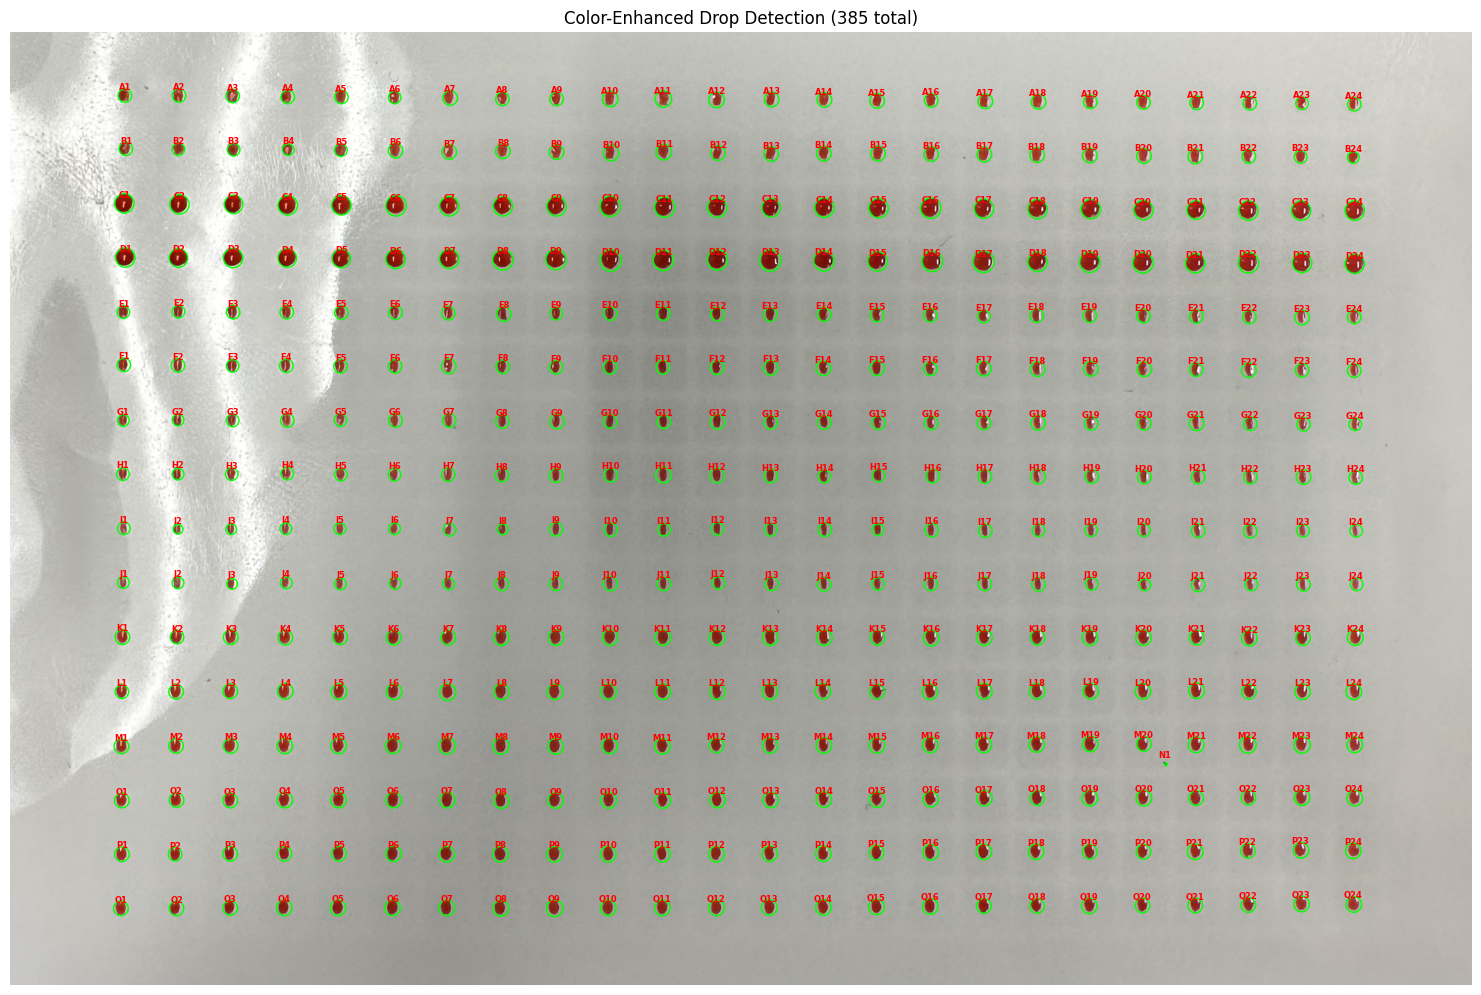

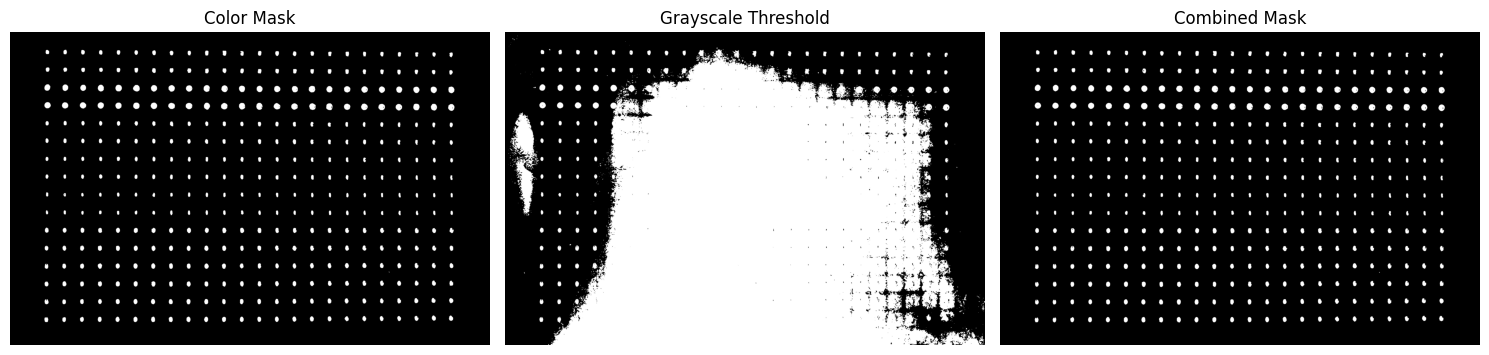

Area Benchmark: 553.1 ± 260.4 px²
Grid dimensions: 17 rows x 24 columns

AREA VARIATION ANALYSIS
Variation Score Legend:
• Green (0.0-1.0): Low variation - consistent with neighbors
• Yellow (1.0-2.0): Medium variation
• Red (2.0+): High variation - significantly different from neighbors
• Each cell shows variation score for that drop position


Row/Col,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
A,0.12,0.15,0.33,0.23,0.07,0.36,0.12,0.20,0.60,0.09,0.60,0.54,0.08,0.19,0.31,0.28,0.44,0.12,0.44,0.03,0.05,0.50,0.29,0.14
B,0.74,0.80,0.71,0.89,0.73,0.69,0.65,0.69,0.68,0.76,0.70,0.83,0.72,0.72,0.71,0.72,0.58,0.66,0.80,0.68,0.63,0.73,0.65,0.78
C,0.78,0.72,0.49,0.80,0.99,0.85,0.57,0.77,0.67,0.78,0.93,0.58,0.51,0.65,0.53,0.95,0.42,0.65,0.82,0.53,0.49,0.60,0.64,0.71
D,0.94,0.82,0.86,0.71,0.61,0.86,0.84,0.83,0.85,0.74,0.80,0.80,1.09,0.85,0.77,0.90,1.11,0.61,0.98,0.92,0.96,1.02,0.79,1.01
E,0.81,0.79,0.80,0.84,0.74,0.84,0.79,0.70,0.83,0.83,0.70,0.83,0.78,0.79,0.79,0.83,0.81,0.79,0.91,0.73,0.87,0.76,0.74,0.73
F,0.18,0.27,0.22,0.11,0.31,0.24,0.20,0.15,0.12,0.22,0.19,0.09,0.45,0.03,0.65,0.22,0.09,0.11,0.46,0.51,0.03,0.12,0.11,0.26
G,0.16,0.34,0.17,0.08,0.08,0.22,0.10,0.15,0.13,0.33,0.19,0.05,0.09,0.19,0.18,0.50,0.12,0.14,0.30,0.07,0.12,0.02,0.20,0.35
H,0.35,0.10,0.15,0.30,0.24,0.17,0.55,0.24,0.12,0.22,0.33,0.36,0.26,0.26,0.24,0.33,0.32,0.23,0.02,0.10,0.51,0.29,0.51,0.27
I,0.03,0.39,0.39,0.18,0.12,0.25,0.42,0.44,0.16,0.20,0.32,0.28,0.37,0.23,0.39,0.08,0.34,0.29,0.00,0.29,0.20,0.00,0.12,0.36
J,0.80,0.60,0.88,0.70,0.87,0.77,0.72,0.60,0.84,0.72,0.56,0.86,0.63,0.66,0.69,0.57,0.73,0.31,0.81,0.80,0.73,0.69,0.65,0.71



Variation Statistics:
Average Variation: 0.42
Max Variation: 3.74
Min Variation: 0.00
Drops with high variation (>2.0): 1

SUMMARY STATISTICS
Average Area: 553.1 ± 260.8 px²
Average Circularity: 0.779 ± 0.076
Average Diameter: 25.9 ± 5.7 px
Average Score: 102.0 ± 17.0


In [8]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pandas as pd
import string
from IPython.display import display, HTML
import io
import base64

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Read image
image = cv2.imread(image_path)
original_image = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
height, width = gray.shape

print(f"Image dimensions: {width} x {height}")

# Color-based drop detection
def create_color_mask(hsv_image):
    """Create a mask for drop-colored objects"""

    # Define color ranges for drops (adjust these based on your drop color)
    # These are broad ranges to catch reddish/brownish drops
    lower_red1 = np.array([0, 30, 30])      # Lower red range
    upper_red1 = np.array([10, 255, 255])

    lower_red2 = np.array([160, 30, 30])    # Upper red range
    upper_red2 = np.array([180, 255, 255])

    lower_brown = np.array([10, 50, 20])    # Brown range
    upper_brown = np.array([25, 255, 200])

    lower_dark = np.array([0, 0, 0])        # Very dark objects
    upper_dark = np.array([180, 255, 80])

    # Create masks for each color range
    mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask_brown = cv2.inRange(hsv_image, lower_brown, upper_brown)
    mask_dark = cv2.inRange(hsv_image, lower_dark, upper_dark)

    # Combine all masks
    color_mask = cv2.bitwise_or(mask_red1, mask_red2)
    color_mask = cv2.bitwise_or(color_mask, mask_brown)
    color_mask = cv2.bitwise_or(color_mask, mask_dark)

    return color_mask

# Create color mask
color_mask = create_color_mask(hsv)

# Also create traditional grayscale mask
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, gray_thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Combine color and grayscale approaches
combined_mask = cv2.bitwise_and(color_mask, gray_thresh)

# Clean up the mask
kernel = np.ones((2,2), np.uint8)
combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Total contours detected: {len(contours)}")

# Score each contour
scored_contours = []

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    if area < 3:  # Very minimal filtering
        continue

    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue

    (x, y), radius = cv2.minEnclosingCircle(cnt)

    # Skip objects at image edges
    margin = 5
    if x < margin or y < margin or x > width - margin or y > height - margin:
        continue

    # Basic shape measurements
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0

    rect = cv2.minAreaRect(cnt)
    w, h = rect[1]
    aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else float('inf')

    x_rect, y_rect, w_rect, h_rect = cv2.boundingRect(cnt)
    extent = area / (w_rect * h_rect) if (w_rect * h_rect) > 0 else 0

    # Color analysis - check the color consistency within the contour
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    # Get average color in the contour region
    mean_color = cv2.mean(hsv, mask=mask)
    hue, sat, val = mean_color[0], mean_color[1], mean_color[2]

    # Calculate comprehensive score
    score = 0

    # Size score (prefer medium sizes)
    if 8 < area < 500:
        score += 30
    elif 4 < area < 800:
        score += 20
    elif area >= 3:
        score += 10

    # Shape scores
    if circularity > 0.3:
        score += circularity * 25

    if solidity > 0.7:
        score += solidity * 20

    if aspect_ratio < 3.0:
        score += max(0, (3.0 - aspect_ratio) / 3.0) * 15

    if extent > 0.5:
        score += extent * 10

    # Color scores (boost for drop-like colors)
    # Dark objects (low value)
    if val < 100:
        score += 25

    # Reddish/brownish objects
    if (0 <= hue <= 25) or (160 <= hue <= 180):
        if sat > 30:
            score += 20

    # Medium saturation (not too gray, not too vivid)
    if 20 < sat < 200:
        score += 15

    # Penalize very bright objects (likely glare)
    if val > 200:
        score -= 20

    # Penalize very large objects (likely artifacts)
    if area > 800:
        score -= 30

    scored_contours.append({
        'contour': cnt,
        'score': score,
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'solidity': solidity,
        'aspect_ratio': aspect_ratio,
        'extent': extent,
        'x': x,
        'y': y,
        'radius': radius,
        'hue': hue,
        'saturation': sat,
        'value': val
    })

# Sort by score (highest first) and take top candidates
scored_contours.sort(key=lambda x: x['score'], reverse=True)
print(f"Scored contours: {len(scored_contours)}")
print(f"Top 10 scores: {[round(c['score'], 1) for c in scored_contours[:10]]}")
print(f"Bottom 10 scores: {[round(c['score'], 1) for c in scored_contours[-10:]]}")

# Take top N candidates (adjust this number as needed)
num_drops = min(400, len(scored_contours))  # Take top 400 or all if fewer
selected_drops = scored_contours[:num_drops]

# Apply proximity filtering to remove duplicates
def proximity_filter(candidates, min_distance=12):
    """Remove candidates that are too close to higher-scored ones"""
    filtered = []

    for candidate in candidates:
        too_close = False
        for existing in filtered:
            dist = np.sqrt((candidate['x'] - existing['x'])**2 + (candidate['y'] - existing['y'])**2)
            if dist < min_distance:
                too_close = True
                break

        if not too_close:
            filtered.append(candidate)

    return filtered

final_drops = proximity_filter(selected_drops, min_distance=12)
print(f"Final drops after proximity filtering: {len(final_drops)}")

# Process selected drops for output
drop_data = []
for drop in final_drops:
    diameter = 2 * np.sqrt(drop['area'] / np.pi)

    drop_data.append({
        'x': drop['x'],
        'y': drop['y'],
        'area': drop['area'],
        'perimeter': drop['perimeter'],
        'circularity': drop['circularity'],
        'diameter': diameter,
        'score': drop['score']
    })

    # Draw circle on image
    cv2.circle(image, (int(drop['x']), int(drop['y'])), max(int(drop['radius']), 3), (0, 255, 0), 2)

# Sort drops into grid pattern
def assign_grid_labels(drop_data, y_tolerance=20):
    if not drop_data:
        return []

    # Sort by y-coordinate first to identify rows
    sorted_by_y = sorted(drop_data, key=lambda d: d['y'])

    # Group into rows based on y-coordinate similarity
    rows = []
    current_row = [sorted_by_y[0]]

    for drop in sorted_by_y[1:]:
        if abs(drop['y'] - current_row[0]['y']) <= y_tolerance:
            current_row.append(drop)
        else:
            rows.append(current_row)
            current_row = [drop]
    rows.append(current_row)

    # Sort each row by x-coordinate and assign labels
    labeled_data = []
    for row_idx, row in enumerate(rows):
        row_sorted = sorted(row, key=lambda d: d['x'])
        row_letter = string.ascii_uppercase[row_idx % 26]

        for col_idx, drop in enumerate(row_sorted):
            drop['label'] = f"{row_letter}{col_idx + 1}"
            labeled_data.append(drop)

    return labeled_data

# Assign grid labels
labeled_drops = assign_grid_labels(drop_data)

# Create DataFrame
df = pd.DataFrame(labeled_drops)
if not df.empty:
    df = df[['label', 'area', 'perimeter', 'circularity', 'diameter', 'score', 'x', 'y']]
    df.columns = ['Drop ID', 'Area (px²)', 'Perimeter (px)', 'Circularity', 'Diameter (px)', 'Score', 'X (px)', 'Y (px)']

    # Round numerical values
    df['Area (px²)'] = df['Area (px²)'].round(1)
    df['Perimeter (px)'] = df['Perimeter (px)'].round(1)
    df['Circularity'] = df['Circularity'].round(3)
    df['Diameter (px)'] = df['Diameter (px)'].round(1)
    df['Score'] = df['Score'].round(1)
    df['X (px)'] = df['X (px)'].round(1)
    df['Y (px)'] = df['Y (px)'].round(1)

# Display results
print(f"\nDetected {len(labeled_drops)} drops using color-enhanced detection")
print("\nDrop Analysis Results:")
display(df)

# CSV Export functionality
def create_download_link(df, filename="drop_analysis.csv"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()
    href = f'<a href="data:file/csv;base64,{b64}" download="{filename}">Download CSV</a>'
    return href

if not df.empty:
    download_link = create_download_link(df)
    display(HTML(f'<p>Export data: {download_link}</p>'))

# Show result image
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Color-Enhanced Drop Detection ({len(labeled_drops)} total)')
plt.axis("off")

# Add labels to the image
for drop in labeled_drops:
    plt.text(drop['x'], drop['y']-10, drop['label'],
             color='red', fontsize=6, fontweight='bold',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Show the masks for debugging
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(color_mask, cmap='gray')
axes[0].set_title('Color Mask')
axes[0].axis('off')

axes[1].imshow(gray_thresh, cmap='gray')
axes[1].set_title('Grayscale Threshold')
axes[1].axis('off')

axes[2].imshow(combined_mask, cmap='gray')
axes[2].set_title('Combined Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Create grid-oriented variation analysis table
def create_variation_grid_table(labeled_drops):
    if not labeled_drops:
        return None

    # Calculate benchmark statistics from all drops
    all_areas = [drop['area'] for drop in labeled_drops]
    benchmark_mean = np.mean(all_areas)
    benchmark_std = np.std(all_areas)

    print(f"Area Benchmark: {benchmark_mean:.1f} ± {benchmark_std:.1f} px²")

    # Create a dictionary for easy lookup by label
    drop_dict = {drop['label']: drop for drop in labeled_drops}

    # Find grid dimensions
    rows = set()
    cols = set()
    for label in drop_dict.keys():
        row_letter = label[0]
        col_number = int(label[1:])
        rows.add(row_letter)
        cols.add(col_number)

    rows = sorted(list(rows))
    cols = sorted(list(cols))

    print(f"Grid dimensions: {len(rows)} rows x {len(cols)} columns")

    # Calculate variation scores
    def get_neighbor_areas(row_letter, col_number):
        """Get areas of neighboring drops"""
        neighbor_areas = []

        # Define neighbor positions (8-directional)
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:  # Skip self
                    continue

                # Calculate neighbor position
                neighbor_row_idx = ord(row_letter) - ord('A') + dr
                neighbor_col = col_number + dc

                # Check bounds
                if 0 <= neighbor_row_idx < len(rows) and neighbor_col >= 1:
                    neighbor_row_letter = chr(ord('A') + neighbor_row_idx)
                    neighbor_label = f"{neighbor_row_letter}{neighbor_col}"

                    if neighbor_label in drop_dict:
                        neighbor_areas.append(drop_dict[neighbor_label]['area'])

        return neighbor_areas

    def calculate_variation_score(drop_area, neighbor_areas, benchmark_mean, benchmark_std):
        """Calculate variation score for a drop"""
        if not neighbor_areas:
            # If no neighbors, compare to benchmark
            variation = abs(drop_area - benchmark_mean) / benchmark_std
        else:
            # Compare to local neighbors
            neighbor_mean = np.mean(neighbor_areas)
            neighbor_std = np.std(neighbor_areas) if len(neighbor_areas) > 1 else benchmark_std

            # Use neighbor std or benchmark std, whichever is larger (more robust)
            std_to_use = max(neighbor_std, benchmark_std * 0.5)
            variation = abs(drop_area - neighbor_mean) / std_to_use

        return variation

    # Create grid data
    grid_data = {}
    variation_scores = []

    for row_letter in rows:
        for col_number in cols:
            label = f"{row_letter}{col_number}"
            if label in drop_dict:
                drop = drop_dict[label]
                neighbor_areas = get_neighbor_areas(row_letter, col_number)

                variation_score = calculate_variation_score(
                    drop['area'], neighbor_areas, benchmark_mean, benchmark_std
                )

                grid_data[label] = {
                    'variation_score': variation_score,
                    'area': drop['area']
                }
                variation_scores.append(variation_score)

    # Normalize variation scores for color mapping (0-1 scale)
    if variation_scores:
        min_var = min(variation_scores)
        max_var = max(variation_scores)
        var_range = max_var - min_var if max_var > min_var else 1

        for label in grid_data:
            normalized = (grid_data[label]['variation_score'] - min_var) / var_range
            grid_data[label]['normalized_variation'] = normalized

    return grid_data, rows, cols, benchmark_mean, benchmark_std

# Generate variation analysis
if not df.empty:
    grid_data, rows, cols, benchmark_mean, benchmark_std = create_variation_grid_table(labeled_drops)

    if grid_data:
        # Create HTML table
        def create_variation_html_table(grid_data, rows, cols):
            html = """
            <style>
            .variation-table {
                border-collapse: collapse;
                margin: 20px 0;
                font-family: Arial, sans-serif;
                font-size: 12px;
            }
            .variation-table th, .variation-table td {
                border: 1px solid #ddd;
                text-align: center;
                padding: 8px;
                min-width: 50px;
            }
            .variation-table th {
                background-color: #f2f2f2;
                font-weight: bold;
            }
            .variation-cell {
                font-weight: bold;
                color: white;
                text-shadow: 1px 1px 1px rgba(0,0,0,0.7);
            }
            </style>

            <table class="variation-table">
            <thead>
            <tr>
            <th>Row/Col</th>
            """

            # Column headers
            for col in cols:
                html += f"<th>{col}</th>"
            html += "</tr></thead><tbody>"

            # Data rows
            for row in rows:
                html += f"<tr><th>{row}</th>"
                for col in cols:
                    label = f"{row}{col}"
                    if label in grid_data:
                        variation_score = grid_data[label]['variation_score']
                        normalized = grid_data[label]['normalized_variation']

                        # Color mapping: green (low variation) to red (high variation)
                        if normalized < 0.5:
                            # Green to yellow
                            red = int(255 * (normalized * 2))
                            green = 255
                            blue = 0
                        else:
                            # Yellow to red
                            red = 255
                            green = int(255 * (2 - normalized * 2))
                            blue = 0

                        bg_color = f"rgb({red},{green},{blue})"
                        html += f'<td class="variation-cell" style="background-color: {bg_color};">{variation_score:.2f}</td>'
                    else:
                        html += '<td style="background-color: #f0f0f0;">-</td>'
                html += "</tr>"

            html += "</tbody></table>"
            return html

        # Display the variation table
        print(f"\n" + "="*50)
        print("AREA VARIATION ANALYSIS")
        print("="*50)
        print(f"Variation Score Legend:")
        print(f"• Green (0.0-1.0): Low variation - consistent with neighbors")
        print(f"• Yellow (1.0-2.0): Medium variation")
        print(f"• Red (2.0+): High variation - significantly different from neighbors")
        print(f"• Each cell shows variation score for that drop position")

        variation_html = create_variation_html_table(grid_data, rows, cols)
        display(HTML(variation_html))

        # Statistics about variation
        all_variations = [data['variation_score'] for data in grid_data.values()]
        print(f"\nVariation Statistics:")
        print(f"Average Variation: {np.mean(all_variations):.2f}")
        print(f"Max Variation: {np.max(all_variations):.2f}")
        print(f"Min Variation: {np.min(all_variations):.2f}")
        print(f"Drops with high variation (>2.0): {sum(1 for v in all_variations if v > 2.0)}")

# Summary statistics
if not df.empty:
    print(f"\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(f"Average Area: {df['Area (px²)'].mean():.1f} ± {df['Area (px²)'].std():.1f} px²")
    print(f"Average Circularity: {df['Circularity'].mean():.3f} ± {df['Circularity'].std():.3f}")
    print(f"Average Diameter: {df['Diameter (px)'].mean():.1f} ± {df['Diameter (px)'].std():.1f} px")
    print(f"Average Score: {df['Score'].mean():.1f} ± {df['Score'].std():.1f}")